In [1]:
import array
import re
import math
import numpy as np
from copy import deepcopy

#======================================================================
#
#             Data Specification 
#
#======================================================================

n = 11 
m = 11 
nelx = 11
nely = 11

Analysis_Type=1
E=30000000           
Poisson=0.3 
density=0.00000783
Thickness=1
AccelX=0
AccelY=-9.81 
NElements=n*m 
NNodes=(n+1)*(m+1)       
NDOF=2*NNodes
NDOFN=2
NBC=13
NLOAD=5 
Material_data=[[Analysis_Type,E,Poisson,Thickness]]
pi=np.arccos(-1)
if Analysis_Type==1:
    print('Type of Analysis: Plane Stress')
else:
    print('Type of Analysis: Plane Strain')
    

#----------------- Creating an array with node data



def numerize(array):
    nodes = np.arange(1,array.shape[0]+1)
    nodes = np.reshape(nodes,(nodes.shape[0],1))
    return np.hstack((nodes,array))

# Initialize coordinates 
coord = np.array([[x, y] for x in range(n+1) for y in range(m+1)])
data1 = numerize(coord)

Node_Data = data1.tolist()

#----------------- Creating an array with element data
elems = []

for elx in range(n):
    for ely in range(m): 
        n1 = (m+1)*(elx)+ely 
        n2 = (m+1)* (elx+1)  +ely
        elems.append([n1+1, n1+2, n2+1, n2+2])

elems = np.array(elems) 
data2 = numerize(elems)
EL_Data = data2.tolist()
    

#----------------- Creating a vector with BC's
total_bc = np.zeros((2*(n+1)*(m+1),1))
total_bc[np.arange(0,2*(m+1)-1)] = 1 
BC = total_bc.tolist()


#----------------- Creating a vector with LOADS

total_loads = np.zeros((2*(n+1)*(m+1),1))
total_loads[2*(n+1)*(m+1)-1] = -20 
LOADS = total_loads.tolist()

#----------------- Creating a vector with Acceleration
Acceleration = [[0 for row in range(1)] for col in range(NDOF)]
for r in range(0,NDOF,2):
    Acceleration[r][0]=AccelX
for r in range(1,NDOF,2):
    Acceleration[r][0]=AccelY
#print(Acceleration)

#======================================================================
#
#             READING ALL DATA FROM EXTERNAL FILE - END
#
#======================================================================
print('END OF USER INPUT PROCESSING')
print('')
print('================= SOLVER ======================')
print('')
print('NUMBER OF NODES IS - '+str(NNodes))
print('NUMBER OF ELEMENTS IS - '+str(NElements))
print('TOTAL NUMBER OF VARIABLES IN THE MODEL - '+str(NDOF))
#===================================================================================
#
#                            FUNCTIONS DEFINITION
#
#===================================================================================

#--------------------------------------- MATRIX MULTIPLICATION FUNCTION ---------------
def matrixmult (A, B):
    rows_A = len(A)
    cols_A = len(A[0])
    rows_B = len(B)
    cols_B = len(B[0])
    C = [[0 for row in range(cols_B)] for col in range(rows_A)]
    for i in range(rows_A):
           for j in range(cols_B):
               for k in range(cols_A):
                   C[i][j] += A[i][k]*B[k][j]
    return C
#--------------------------------------- MATRIX SUM FUNCTION ---------------
def matrixsum (A, B):
   C = [[0 for row in range(len(A))] for col in range(len(A[0]))]
   for i in range(len(A)):
    for j in range(len(A[0])):
     C[i][j] = A[i][j] + B[i][j]
   return C
#--------------------------------------- MATRIX MULTIPLICATION FUNCTION by an SCALAR ---------------
def matrixscalarmult(A,b):
   for row in A :
    Multiscalar = [[A[i][j]*b for i in range(len(A))] for j in range(len(A[0]))]
   return Multiscalar
#--------------------------------------- MATRIX TRANSPOSE FUNCTION ---------------
def transpose(A):
   for row in A :
    Trans = [[A[j][i] for j in range(len(A))] for i in range(len(A[0]))]
   return Trans
#===================================================================================
#
#
#
#                                      FEA CODE
#
#
#
#===================================================================================
#----------------------------Integration Points Coordinates (4 integration points)
s1=-0.577350269
t1=-0.577350269
s2=0.577350269
t2=-0.577350269
s3=0.577350269
t3=0.577350269
s4=-0.577350269
t4=0.577350269
#-----------------------------------Filling Global Stiffness Matrix with zeros
KG = [[0 for row in range(NDOF)] for col in range(NDOF)]
LOADS_total= [[0 for row in range(1)] for col in range(NDOF)]
#-----------------------------------Filling Global Mass Matrix with zeros
Mmatrix = [[0 for row in range(NDOF)] for col in range(NDOF)]
#-----------------------------------Filling Results Matrix for each element with zeros
Disp_elem = [[0 for row in range(1)] for col in range(8)]
StressX = [[0 for row in range(1)] for col in range(4)]
StressY = [[0 for row in range(1)] for col in range(4)]
StressXY = [[0 for row in range(1)] for col in range(4)]
StressPrinc1 = [[0 for row in range(1)] for col in range(4)]
StressPrinc2 = [[0 for row in range(1)] for col in range(4)]
StressVM = [[0 for row in range(1)] for col in range(4)]
StressX_EXTRAP=[[0 for row in range(1)] for col in range(4)]
StressY_EXTRAP=[[0 for row in range(1)] for col in range(4)]
StressXY_EXTRAP=[[0 for row in range(1)] for col in range(4)]
StressPrinc1_EXTRAP=[[0 for row in range(1)] for col in range(4)]
StressPrinc2_EXTRAP=[[0 for row in range(1)] for col in range(4)]
StressVM_EXTRAP=[[0 for row in range(1)] for col in range(4)]
Strains_integrationpoint1=[[0 for row in range(1)] for col in range(3)]
Strains_integrationpoint2=[[0 for row in range(1)] for col in range(3)]
Strains_integrationpoint3=[[0 for row in range(1)] for col in range(3)]
Strains_integrationpoint4=[[0 for row in range(1)] for col in range(3)]
PARAVIEW_RESULTS=[[None for row in range(72)] for col in range(NNodes)]
for r in range(0,NNodes):
    PARAVIEW_RESULTS[r][0]=Node_Data[r][0]
#------------------- nodal extrapolation matrix -------------------------
EXTRAP=[[1+0.5*3**0.5,-0.5,1-0.5*3**0.5,-0.5],[-0.5,1+0.5*3**0.5,-0.5,1-0.5*3**0.5],[1-0.5*3**0.5,-0.5,1+0.5*3**0.5,-0.5],[-0.5,1-0.5*3**0.5,-0.5,1+0.5*3**0.5]]
#==================================Defining material behavior - Plane stress or Plane strain
if Analysis_Type == 1:
    D=[[E/(1-Poisson * Poisson),(Poisson*E)/(1-Poisson * Poisson),0],
        [(Poisson*E)/(1-Poisson * Poisson),E/(1-Poisson * Poisson),0],[0,0,((1-Poisson)/2*E)/(1-Poisson * Poisson)]]
else:
    D=[[E/((1+Poisson)*(1-2*Poisson))*(1-Poisson),Poisson*E/((1+Poisson)*(1-2*Poisson)),0],
        [Poisson * (E / ((1 + Poisson) * (1 - 2 * Poisson))),E / ((1 + Poisson) * (1 - 2 * Poisson)) * (1 - Poisson),0],
         [0,0,E / ((1 + Poisson) * (1 - 2 * Poisson)) * ((1 - 2 * Poisson) / 2)]]

#========================================================================================
#
#                               ELEMENT STIFFNESS MATRIX
#
#========================================================================================
for i in range(1,NElements+1):

          XCOORD=[[Node_Data[EL_Data[i-1][1]-1][1],Node_Data[EL_Data[i-1][2]-1][1],Node_Data[EL_Data[i-1][3]-1][1],Node_Data[EL_Data[i-1][4]-1][1]]]
          YCOORD=[[Node_Data[EL_Data[i-1][1]-1][2],Node_Data[EL_Data[i-1][2]-1][2],Node_Data[EL_Data[i-1][3]-1][2],Node_Data[EL_Data[i-1][4]-1][2]]]

#------------------------------------- Jacobian Determinant -------------------------------------------------

          def DetJacobian(s,t):
            J=[[0,0],[0,0]]
            J[0][0]=(t-1)*XCOORD[0][0]+(1-t)*XCOORD[0][1]+(1+t)*XCOORD[0][2]-(1+t)*XCOORD[0][3]
            J[0][1]=(t-1)*YCOORD[0][0]+(1-t)*YCOORD[0][1]+(1+t)*YCOORD[0][2]-(1+t)*YCOORD[0][3]
            J[1][0]=(s-1)*XCOORD[0][0]-(1+s)*XCOORD[0][1]+(1+s)*XCOORD[0][2]+(1-s)*XCOORD[0][3]
            J[1][1]=(s-1)*YCOORD[0][0]-(1+s)*YCOORD[0][1]+(1+s)*YCOORD[0][2]+(1-s)*YCOORD[0][3]
            return (J[0][0]*J[1][1]-J[0][1]*J[1][0])/16.0
#------------------------------------- Matrix B -------------------------------------------------

          def BMatrix(s,t):
           B=[[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]]
           a = 0.25 * (YCOORD[0][0] * (s - 1) + YCOORD[0][1] * (-1 - s) + YCOORD[0][2] * (1 + s) + YCOORD[0][3] * (1 - s))
           b = 0.25 * (YCOORD[0][0] * (t - 1) + YCOORD[0][1] * (1 - t) + YCOORD[0][2] * (1 + t) + YCOORD[0][3] * (-1 - t))
           c = 0.25 * (XCOORD[0][0] * (t - 1) + XCOORD[0][1] * (1 - t) + XCOORD[0][2] * (1 + t) + XCOORD[0][3] * (-1 - t))
           d = 0.25 * (XCOORD[0][0] * (s - 1) + XCOORD[0][1] * (-1 - s) + XCOORD[0][2] * (1 + s) + XCOORD[0][3] * (1 - s))

           B[0][0]=((a * 0.25 * (t - 1) - b * 0.25 * (s - 1)))/DetJacobian(s,t)
           B[1][0]=0
           B[2][0]=(c * 0.25 * (s - 1) - d * 0.25 * (t - 1))/DetJacobian(s,t)
   
           B[0][1]=0
           B[1][1]=(c * 0.25 * (s - 1) - d * 0.25 * (t - 1))/DetJacobian(s,t)
           B[2][1]=(a * 0.25 * (t - 1) - b * 0.25 * (s - 1))/DetJacobian(s,t)

           B[0][2]=(a * 0.25 * (1 - t) - b * 0.25 * (-1 - s))/DetJacobian(s,t)
           B[1][2]=0
           B[2][2]=(c * 0.25 * (-1 - s) - d * 0.25 * (1 - t))/DetJacobian(s,t)

           B[0][3]=0
           B[1][3]=(c * 0.25 * (-1 - s) - d * 0.25 * (1 - t))/DetJacobian(s,t)
           B[2][3]=(a * 0.25 * (1 - t) - b * 0.25 * (-1 - s))/DetJacobian(s,t)

           B[0][4]=(a * 0.25 * (1 + t) - b * 0.25 * (1 + s))/DetJacobian(s,t)
           B[1][4]=0
           B[2][4]=(c * 0.25 * (1 + s) - d * 0.25 * (1 + t))/DetJacobian(s,t)

           B[0][5]=0
           B[1][5]=(c * 0.25 * (1 + s) - d * 0.25 * (1 + t))/DetJacobian(s,t)
           B[2][5]=(a * 0.25 * (1 + t) - b * 0.25 * (1 + s))/DetJacobian(s,t)

           B[0][6]=(a * 0.25 * (-1 - t) - b * 0.25 * (1 - s))/DetJacobian(s,t)
           B[1][6]=0
           B[2][6]=(c * 0.25 * (1 - s) - d * 0.25 * (-1 - t))/DetJacobian(s,t)

           B[0][7]=0
           B[1][7]=(c * 0.25 * (1 - s) - d * 0.25 * (-1 - t))/DetJacobian(s,t)
           B[2][7]=(a * 0.25 * (-1 - t) - b * 0.25 * (1 - s))/DetJacobian(s,t)
 
   
           return B

          Ke1= matrixscalarmult(matrixscalarmult(matrixmult (transpose(BMatrix(s1,t1)),matrixmult(D, BMatrix(s1,t1))),DetJacobian(s1,t1)),Thickness)
          Ke2=matrixscalarmult(matrixscalarmult(matrixmult (transpose(BMatrix(s2,t2)),matrixmult(D, BMatrix(s2,t2))),DetJacobian(s2,t2)),Thickness)
          Ke3=matrixscalarmult(matrixscalarmult(matrixmult (transpose(BMatrix(s3,t3)),matrixmult(D, BMatrix(s3,t3))),DetJacobian(s3,t3)),Thickness)
          Ke4=matrixscalarmult(matrixscalarmult(matrixmult (transpose(BMatrix(s4,t4)),matrixmult(D, BMatrix(s4,t4))),DetJacobian(s4,t4)),Thickness)

          Ke=matrixsum(matrixsum(matrixsum(Ke1, Ke2),Ke3),Ke4)
#------------------------------------- MASS Matrix -------------------------------------------------
          def NMatrix(s,t):
           NMatrix=[[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]]

           NMatrix[0][0]=((1-s)*(1-t)/4)
           NMatrix[1][0]=0
              
           NMatrix[0][1]=0
           NMatrix[1][1]=((1-s)*(1-t)/4)
           
           NMatrix[0][2]=((1+s)*(1-t)/4)
           NMatrix[1][2]=0
           
           NMatrix[0][3]=0
           NMatrix[1][3]=((1+s)*(1-t)/4)
           
           NMatrix[0][4]=((1+s)*(1+t)/4)
           NMatrix[1][4]=0
           
           NMatrix[0][5]=0
           NMatrix[1][5]=((1+s)*(1+t)/4)
           
           NMatrix[0][6]=((1-s)*(1+t)/4)
           NMatrix[1][6]=0
           
           NMatrix[0][7]=0
           NMatrix[1][7]=((1-s)*(1+t)/4)
            
   
           return NMatrix
          MassMatrix1=matrixscalarmult(matrixscalarmult(matrixscalarmult(matrixmult (transpose(NMatrix(s1,t1)),NMatrix(s1,t1)),DetJacobian(s1,t1)),Thickness),density)
          MassMatrix2=matrixscalarmult(matrixscalarmult(matrixscalarmult(matrixmult (transpose(NMatrix(s2,t2)),NMatrix(s2,t2)),DetJacobian(s2,t2)),Thickness),density)
          MassMatrix3=matrixscalarmult(matrixscalarmult(matrixscalarmult(matrixmult (transpose(NMatrix(s3,t3)),NMatrix(s3,t3)),DetJacobian(s3,t3)),Thickness),density)
          MassMatrix4=matrixscalarmult(matrixscalarmult(matrixscalarmult(matrixmult (transpose(NMatrix(s4,t4)),NMatrix(s4,t4)),DetJacobian(s4,t4)),Thickness),density)

          MassMatrixelement=matrixsum(matrixsum(matrixsum(MassMatrix1, MassMatrix2),MassMatrix3),MassMatrix4)
#*************************************************************************************
                # GLOBAL STIFFNESS ANS MASS MATRIX ASSEMBLY
#*************************************************************************************                    
          for r in range(0,4):
              for t in range(0,2):
                  for z in range(0,4):
                      for m in range(0,2):
                          rw = NDOFN*(EL_Data[i-1][r+1]-1)+t
                          cl = NDOFN*(EL_Data[i-1][z+1]-1)+m
                          KG[rw][cl] = KG[rw][cl]+Ke[NDOFN * (r) + t][NDOFN * (z) + m]
                          Mmatrix[rw][cl] = Mmatrix[rw][cl]+MassMatrixelement[NDOFN * (r) + t][NDOFN * (z) + m]

#print (KG)
print('GLOBAL STIFFNESS MATRIX READY')
#print(Mmatrix)


#*************************************************************************************
                    # BODY FORCE + LOADS 
#*************************************************************************************
LOADS_total=np.add(matrixmult(Mmatrix,Acceleration),LOADS)
#--------------removing the body forces for the nodes with BCs
index=0
while index < (NDOF):
    if BC[index][0]==1:
        LOADS_total[index][0]=0
    else:
        LOADS_total[index][0]=LOADS_total[index][0]
    index = index +1
#print(LOADS_total)                    
#*************************************************************************************
                    # APPLYING BOUNDARY CONDITIONS
#*************************************************************************************
#--------------Filling Global AUXILIAR Stiffness Matrix with zeros
KG2 = [[0 for row in range(NDOF)] for col in range(NDOF)]
#----------------------------------------------------------------------------
index=0
while index < (NDOF):
    if BC[index][0]==1:
        for r in range(0,NDOF):
            if r==index:
                KG2[index][r]=1
            else:
                KG2[index][r]=0
                KG2[r][index]=0
    else:
        for r in range(index,NDOF):
            KG2[index][r]=KG[index][r]
        for t in range(index,NDOF):
            KG2[t][index]=KG[t][index]
    index = index +1
#print (KG2)
print('BOUNDARY CONDITIONS APPLIED')        
#*************************************************************************************
                         #Solving {U} = [K]^(-1) x {F}
#*************************************************************************************
#------------------------- Inverting the KG2 Matrix ---------------------
print('INVERTING GLOBAL STIFFNESS MATRIX')
KGINV=np.linalg.pinv(KG2) #--------------- used Moore-Penrose pseudo-inverse scheme
#KGINV=invert(KG2)
#print (KGINV)
print('GLOBAL STIFFNESS MATRIX INVERTED')
#------------------------- Calculating the nodal displacements (U = [K]^(-1) x {F}) ---------------------
Displacement = matrixmult(KGINV, LOADS_total)

#print(Displacement)
print('SYSTEM OF EQUATIONS SOLUTION IS DONE!')
print('')
print('=============== POST-PROCESSOR =================')
print('')
print('STARTING POST-PROCESS DATA')

#======================================================================
#
#                          POST PROCESSING
#
#======================================================================
for i in range(1,NElements+1):

          XCOORD=[[Node_Data[EL_Data[i-1][1]-1][1],Node_Data[EL_Data[i-1][2]-1][1],Node_Data[EL_Data[i-1][3]-1][1],Node_Data[EL_Data[i-1][4]-1][1]]]
          YCOORD=[[Node_Data[EL_Data[i-1][1]-1][2],Node_Data[EL_Data[i-1][2]-1][2],Node_Data[EL_Data[i-1][3]-1][2],Node_Data[EL_Data[i-1][4]-1][2]]]

#------------------------------------- Jacobian Determinant -------------------------------------------------

          def DetJacobian(s,t):
            J=[[0,0],[0,0]]
            J[0][0]=(t-1)*XCOORD[0][0]+(1-t)*XCOORD[0][1]+(1+t)*XCOORD[0][2]-(1+t)*XCOORD[0][3]
            J[0][1]=(t-1)*YCOORD[0][0]+(1-t)*YCOORD[0][1]+(1+t)*YCOORD[0][2]-(1+t)*YCOORD[0][3]
            J[1][0]=(s-1)*XCOORD[0][0]-(1+s)*XCOORD[0][1]+(1+s)*XCOORD[0][2]+(1-s)*XCOORD[0][3]
            J[1][1]=(s-1)*YCOORD[0][0]-(1+s)*YCOORD[0][1]+(1+s)*YCOORD[0][2]+(1-s)*YCOORD[0][3]
            return (J[0][0]*J[1][1]-J[0][1]*J[1][0])/16.0
#------------------------------------- Matrix B -------------------------------------------------

          def BMatrix(s,t):
           B=[[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]]
           a = 0.25 * (YCOORD[0][0] * (s - 1) + YCOORD[0][1] * (-1 - s) + YCOORD[0][2] * (1 + s) + YCOORD[0][3] * (1 - s))
           b = 0.25 * (YCOORD[0][0] * (t - 1) + YCOORD[0][1] * (1 - t) + YCOORD[0][2] * (1 + t) + YCOORD[0][3] * (-1 - t))
           c = 0.25 * (XCOORD[0][0] * (t - 1) + XCOORD[0][1] * (1 - t) + XCOORD[0][2] * (1 + t) + XCOORD[0][3] * (-1 - t))
           d = 0.25 * (XCOORD[0][0] * (s - 1) + XCOORD[0][1] * (-1 - s) + XCOORD[0][2] * (1 + s) + XCOORD[0][3] * (1 - s))

           B[0][0]=((a * 0.25 * (t - 1) - b * 0.25 * (s - 1)))/DetJacobian(s,t)
           B[1][0]=0
           B[2][0]=(c * 0.25 * (s - 1) - d * 0.25 * (t - 1))/DetJacobian(s,t)
   
           B[0][1]=0
           B[1][1]=(c * 0.25 * (s - 1) - d * 0.25 * (t - 1))/DetJacobian(s,t)
           B[2][1]=(a * 0.25 * (t - 1) - b * 0.25 * (s - 1))/DetJacobian(s,t)

           B[0][2]=(a * 0.25 * (1 - t) - b * 0.25 * (-1 - s))/DetJacobian(s,t)
           B[1][2]=0
           B[2][2]=(c * 0.25 * (-1 - s) - d * 0.25 * (1 - t))/DetJacobian(s,t)

           B[0][3]=0
           B[1][3]=(c * 0.25 * (-1 - s) - d * 0.25 * (1 - t))/DetJacobian(s,t)
           B[2][3]=(a * 0.25 * (1 - t) - b * 0.25 * (-1 - s))/DetJacobian(s,t)

           B[0][4]=(a * 0.25 * (1 + t) - b * 0.25 * (1 + s))/DetJacobian(s,t)
           B[1][4]=0
           B[2][4]=(c * 0.25 * (1 + s) - d * 0.25 * (1 + t))/DetJacobian(s,t)

           B[0][5]=0
           B[1][5]=(c * 0.25 * (1 + s) - d * 0.25 * (1 + t))/DetJacobian(s,t)
           B[2][5]=(a * 0.25 * (1 + t) - b * 0.25 * (1 + s))/DetJacobian(s,t)

           B[0][6]=(a * 0.25 * (-1 - t) - b * 0.25 * (1 - s))/DetJacobian(s,t)
           B[1][6]=0
           B[2][6]=(c * 0.25 * (1 - s) - d * 0.25 * (-1 - t))/DetJacobian(s,t)

           B[0][7]=0
           B[1][7]=(c * 0.25 * (1 - s) - d * 0.25 * (-1 - t))/DetJacobian(s,t)
           B[2][7]=(a * 0.25 * (-1 - t) - b * 0.25 * (1 - s))/DetJacobian(s,t)
 
   
           return B
#------------------------------------ [D] X [B] MATRIX -------------------------------------
          DB1= matrixmult(D,BMatrix(s1,t1))
          DB2= matrixmult(D,BMatrix(s2,t2))
          DB3= matrixmult(D,BMatrix(s3,t3))
          DB4= matrixmult(D,BMatrix(s4,t4))
#--------------Vector with the displacements for each node in one element [8 x 1]-----------
          Disp_elem[0][0]=Displacement[2*(EL_Data[i-1][1])-2][0]
          Disp_elem[1][0]=Displacement[2*(EL_Data[i-1][1])-1][0]
          Disp_elem[2][0]=Displacement[2*(EL_Data[i-1][2])-2][0]
          Disp_elem[3][0]=Displacement[2*(EL_Data[i-1][2])-1][0]
          Disp_elem[4][0]=Displacement[2*(EL_Data[i-1][3])-2][0]
          Disp_elem[5][0]=Displacement[2*(EL_Data[i-1][3])-1][0]
          Disp_elem[6][0]=Displacement[2*(EL_Data[i-1][4])-2][0]
          Disp_elem[7][0]=Displacement[2*(EL_Data[i-1][4])-1][0]
#------------------------ strain matrix (ex,ey and exy) for each integration point -------------------------
          Strains_integrationpoint1=matrixmult(BMatrix(s1,t1),Disp_elem)
          Strains_integrationpoint2=matrixmult(BMatrix(s2,t2),Disp_elem)
          Strains_integrationpoint3=matrixmult(BMatrix(s3,t3),Disp_elem)
          Strains_integrationpoint4=matrixmult(BMatrix(s4,t4),Disp_elem)
#------------------------ stress matrix (X,Y and XY) for each integration point -------------------------
          Stress_integrationpoint1=matrixmult(DB1,Disp_elem)
          Stress_integrationpoint2=matrixmult(DB2,Disp_elem)
          Stress_integrationpoint3=matrixmult(DB3,Disp_elem)
          Stress_integrationpoint4=matrixmult(DB4,Disp_elem)
#------------------------ Sx stress vector ------------------------
          StressX[0][0]=Stress_integrationpoint1[0][0]
          StressX[1][0]=Stress_integrationpoint2[0][0]
          StressX[2][0]=Stress_integrationpoint3[0][0]
          StressX[3][0]=Stress_integrationpoint4[0][0]
#------------------------ Sy stress vector -------------------------
          StressY[0][0]=Stress_integrationpoint1[1][0]
          StressY[1][0]=Stress_integrationpoint2[1][0]
          StressY[2][0]=Stress_integrationpoint3[1][0]
          StressY[3][0]=Stress_integrationpoint4[1][0]
#------------------------ Sxy stress vector -------------------------
          StressXY[0][0]=Stress_integrationpoint1[2][0]
          StressXY[1][0]=Stress_integrationpoint2[2][0]
          StressXY[2][0]=Stress_integrationpoint3[2][0]
          StressXY[3][0]=Stress_integrationpoint4[2][0]
#------------------------ Princiapl 1 stress vector -------------------------
          StressPrinc1[0][0]=(StressX[0][0]+StressY[0][0])/2+(((StressX[0][0]-StressY[0][0])/2)**2+(StressXY[0][0])**2)**0.5
          StressPrinc1[1][0]=(StressX[1][0]+StressY[1][0])/2+(((StressX[1][0]-StressY[1][0])/2)**2+(StressXY[1][0])**2)**0.5
          StressPrinc1[2][0]=(StressX[2][0]+StressY[2][0])/2+(((StressX[2][0]-StressY[2][0])/2)**2+(StressXY[2][0])**2)**0.5
          StressPrinc1[3][0]=(StressX[3][0]+StressY[3][0])/2+(((StressX[3][0]-StressY[3][0])/2)**2+(StressXY[3][0])**2)**0.5
#------------------------ Princiapl 2 stress vector -------------------------
          StressPrinc2[0][0]=(StressX[0][0]+StressY[0][0])/2-(((StressX[0][0]-StressY[0][0])/2)**2+(StressXY[0][0])**2)**0.5
          StressPrinc2[1][0]=(StressX[1][0]+StressY[1][0])/2-(((StressX[1][0]-StressY[1][0])/2)**2+(StressXY[1][0])**2)**0.5
          StressPrinc2[2][0]=(StressX[2][0]+StressY[2][0])/2-(((StressX[2][0]-StressY[2][0])/2)**2+(StressXY[2][0])**2)**0.5
          StressPrinc2[3][0]=(StressX[3][0]+StressY[3][0])/2-(((StressX[3][0]-StressY[3][0])/2)**2+(StressXY[3][0])**2)**0.5
#------------------------ VON MISES stress vector ------------------------
          StressVM[0][0]=((StressPrinc1[0][0])**2-StressPrinc1[0][0]*StressPrinc2[0][0]+(StressPrinc2[0][0])**2)**0.5
          StressVM[1][0]=((StressPrinc1[1][0])**2-StressPrinc1[1][0]*StressPrinc2[1][0]+(StressPrinc2[1][0])**2)**0.5
          StressVM[2][0]=((StressPrinc1[2][0])**2-StressPrinc1[2][0]*StressPrinc2[2][0]+(StressPrinc2[2][0])**2)**0.5
          StressVM[3][0]=((StressPrinc1[3][0])**2-StressPrinc1[3][0]*StressPrinc2[3][0]+(StressPrinc2[3][0])**2)**0.5

#=============================== RESULTS EXTRAPOLATED TO THE NODES =======================================

          StressX_EXTRAP= matrixmult(EXTRAP,StressX)
          StressY_EXTRAP= matrixmult(EXTRAP,StressY)
          StressXY_EXTRAP= matrixmult(EXTRAP,StressXY)
          StressPrinc1_EXTRAP= matrixmult(EXTRAP,StressPrinc1)
          StressPrinc2_EXTRAP= matrixmult(EXTRAP,StressPrinc2)
          StressVM_EXTRAP= matrixmult(EXTRAP,StressVM)
        
          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][1]=StressX[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][2]=StressX[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][3]=StressX[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][4]=StressX[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][6]=StressY[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][7]=StressY[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][8]=StressY[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][9]=StressY[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][11]=StressXY[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][12]=StressXY[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][13]=StressXY[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][14]=StressXY[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][16]=StressPrinc1[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][17]=StressPrinc1[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][18]=StressPrinc1[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][19]=StressPrinc1[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][21]=StressPrinc2[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][22]=StressPrinc2[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][23]=StressPrinc2[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][24]=StressPrinc2[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][26]=StressVM[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][27]=StressVM[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][28]=StressVM[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][29]=StressVM[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][36]=StressX_EXTRAP[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][37]=StressX_EXTRAP[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][38]=StressX_EXTRAP[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][39]=StressX_EXTRAP[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][41]=StressY_EXTRAP[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][42]=StressY_EXTRAP[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][43]=StressY_EXTRAP[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][44]=StressY_EXTRAP[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][46]=StressXY_EXTRAP[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][47]=StressXY_EXTRAP[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][48]=StressXY_EXTRAP[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][49]=StressXY_EXTRAP[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][51]=StressPrinc1_EXTRAP[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][52]=StressPrinc1_EXTRAP[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][53]=StressPrinc1_EXTRAP[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][54]=StressPrinc1_EXTRAP[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][56]=StressPrinc2_EXTRAP[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][57]=StressPrinc2_EXTRAP[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][58]=StressPrinc2_EXTRAP[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][59]=StressPrinc2_EXTRAP[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][61]=StressVM_EXTRAP[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][62]=StressVM_EXTRAP[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][63]=StressVM_EXTRAP[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][64]=StressVM_EXTRAP[3][0]

          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][66]=Strains_integrationpoint1[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][66]=Strains_integrationpoint2[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][66]=Strains_integrationpoint3[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][66]=Strains_integrationpoint4[0][0]
          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][70]=Strains_integrationpoint1[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][70]=Strains_integrationpoint2[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][70]=Strains_integrationpoint3[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][70]=Strains_integrationpoint4[1][0]
          PARAVIEW_RESULTS[EL_Data[i-1][1]-1][71]=Strains_integrationpoint1[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][2]-1][71]=Strains_integrationpoint2[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][3]-1][71]=Strains_integrationpoint3[2][0]
          PARAVIEW_RESULTS[EL_Data[i-1][4]-1][71]=Strains_integrationpoint4[2][0]
        
        

for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(1,5):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print (i)
    PARAVIEW_RESULTS[i][5]=Sum/k
#------------------------------------ SY        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(6,10):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print(i)
    PARAVIEW_RESULTS[i][10]=Sum/k
#------------------------------------ SXY        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(11,15):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print(i)
    PARAVIEW_RESULTS[i][15]=Sum/k
#------------------------------------ S1        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(16,20):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print(i)
    PARAVIEW_RESULTS[i][20]=Sum/k

#------------------------------------ S2        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(21,25):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print(i)
    PARAVIEW_RESULTS[i][25]=Sum/k

#------------------------------------ VM        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(26,30):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print(i)
    PARAVIEW_RESULTS[i][30]=Sum/k
#------------------------------------ SX EXTRAPOLATED        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(36,40):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print(i)
    PARAVIEW_RESULTS[i][40]=Sum/k

#------------------------------------ SY EXTRAPOLATED        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(41,45):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print(i)
    PARAVIEW_RESULTS[i][45]=Sum/k

#------------------------------------ SXY EXTRAPOLATED        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(46,50):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
       print(i)
    PARAVIEW_RESULTS[i][50]=Sum/k
#------------------------------------ S1 EXTRAPOLATED        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(51,55):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print(i)
    PARAVIEW_RESULTS[i][55]=Sum/k
#------------------------------------ S2 EXTRAPOLATED        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(56,60):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print (i)
    PARAVIEW_RESULTS[i][60]=Sum/k
#------------------------------------ VM EXTRAPOLATED        
for i in range(0,NNodes):
    k=0
    Sum=0
    for j in range(61,65):
        if PARAVIEW_RESULTS[i][j]!=None:
            k=k+1
            Sum=Sum+PARAVIEW_RESULTS[i][j]
    if k==0:
        print(i)
    PARAVIEW_RESULTS[i][65]=Sum/k

#------------------------------------ VECTORS RESULTS
for i in range(0,NNodes):
    PARAVIEW_RESULTS[i][31] = np.arctan((2*PARAVIEW_RESULTS[i][15])/(PARAVIEW_RESULTS[i][5]-PARAVIEW_RESULTS[i][10]))/2*180/np.pi
for i in range(0,NNodes):
    PARAVIEW_RESULTS[i][32] = np.cos(PARAVIEW_RESULTS[i][31]/(180/np.pi))*PARAVIEW_RESULTS[i][20]
for i in range(0,NNodes):
    PARAVIEW_RESULTS[i][33] = np.sin(PARAVIEW_RESULTS[i][31]/(180/np.pi))*PARAVIEW_RESULTS[i][20]
for i in range(0,NNodes):
    PARAVIEW_RESULTS[i][34] = np.sin(PARAVIEW_RESULTS[i][31]/(180/np.pi))*PARAVIEW_RESULTS[i][25]
for i in range(0,NNodes):
    PARAVIEW_RESULTS[i][35] = np.cos(PARAVIEW_RESULTS[i][31]/(180/np.pi))*PARAVIEW_RESULTS[i][25]

Type of Analysis: Plane Stress
END OF USER INPUT PROCESSING

================= SOLVER ======================

NUMBER OF NODES IS - 144
NUMBER OF ELEMENTS IS - 121
TOTAL NUMBER OF VARIABLES IN THE MODEL - 288
GLOBAL STIFFNESS MATRIX READY
BOUNDARY CONDITIONS APPLIED
INVERTING GLOBAL STIFFNESS MATRIX
GLOBAL STIFFNESS MATRIX INVERTED
SYSTEM OF EQUATIONS SOLUTION IS DONE!

=============== POST-PROCESSOR =================

STARTING POST-PROCESS DATA


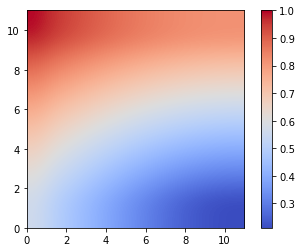

In [50]:
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d

res = np.array(PARAVIEW_RESULTS) 
res[res==None] = 0 
vonmises = np.array(res[:,30]).astype(np.float)
vonmises_norm = vonmises/np.max(vonmises)

x = np.array(Node_Data)[:,1]
y = np.array(Node_Data)[:,2]
f = interp2d(x,y,vonmises_norm,kind="linear")


x_coords = np.arange(min(x),max(x)+1)
y_coords = np.arange(min(y),max(y)+1)
f_i = f(x_coords,y_coords)

fig = plt.imshow(f_i,
           extent=[min(x),max(x),min(y),max(y)],
           origin="lower", interpolation='bicubic', cmap=cm.coolwarm)

# Show the positions of the sample points, just to have some reference

fig.axes.set_autoscale_on(False)
plt.colorbar()
plt.show()


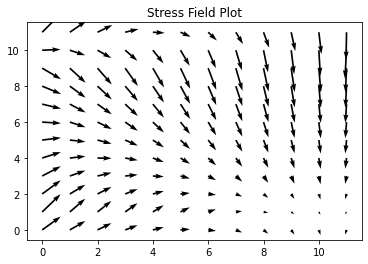

In [51]:
# Stress field with direction 
ps1 = np.array(res[:,50]).astype(np.float)
ps2 = np.array(res[:,55]).astype(np.float)

ps1 = ps1/np.max(ps1)
ps2 = ps2/np.max(ps2)

plt.figure()
plt.title('Stress Field Plot')
Q = plt.quiver(x, y, ps1, ps2, units='width')


plt.show()



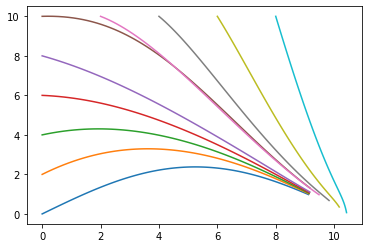

In [52]:
# Track the evolution of a point based on the line 
from math import factorial as fac

def Choose(n,k): 
    return  fac(n)/ fac(k) / fac( n - k )

class nBezier(object):
    def __init__(self, points):
        self.points = np.array(points).astype(np.float32)

    def at(self, t):
        pt = 0 
        n= len(self.points)
        for k in range(n): 
            pt +=  Choose(n-1,k) * (1-t)**(n-1-k) * t**k * self.points[k]
        return pt

# Create the first set of start points
strt_pts1 = np.zeros((int(nelx/2),2))
strt_pts2 = np.zeros((int(nely/2),2))
strt_pts1[:,0] = np.arange(0,nelx-1,2)
strt_pts1[:,1] = nely-1
strt_pts2[:,1] = np.arange(0,nely-1,2)

strt_pts = np.concatenate((strt_pts2,strt_pts1),axis=0) 

# Length of the segments 
length = 2
iterations = 10

f0 = interp2d(x,y,ps1,kind="linear") 
f1 = interp2d(x,y,ps2,kind="linear") 
total_pts = [] 
for j in range(strt_pts.shape[0]):
    strt_pt = strt_pts[j,:] 
    pts = []
    pts.append(strt_pt)
    for i in range(iterations):
        pt_x = strt_pt[0]+ length*f0(strt_pt[0],strt_pt[1])
        pt_y = strt_pt[1]+ length*f1(strt_pt[0],strt_pt[1])
        strt_pt = [float(pt_x),float(pt_y)]
        pts.append(strt_pt)
    pts = np.array(pts) 
    total_pts.append(pts)

total_pts = np.array(total_pts)

t = np.linspace(0,1,100) 

# Create an array for the bezier curves 
bez_list1 =[] 
for  j in range(total_pts.shape[0]):
    Curve  = nBezier(total_pts[j,:,:])
    list_of_pts = []
    for  item in t:
        list_of_pts.append(Curve.at(item))
        
    bez_list1.append(list_of_pts)
    list_of_pts = np.array(list_of_pts)
    
    plt.plot(list_of_pts[:,0],list_of_pts[:,1])
#plt.show()

bez_list2 =[] 

'''
for  j in range(total_pts.shape[1]):
    Curve  = nBezier(total_pts[:,j,:])
    list_of_pts = []
    for  item in t:
        list_of_pts.append(Curve.at(item))
        
    bez_list2.append(list_of_pts)
    list_of_pts = np.array(list_of_pts)
    plt.plot(list_of_pts[:,0],list_of_pts[:,1])


'''
plt.savefig('StressLines2.png')
plt.show()



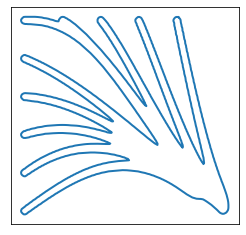

'\n'

In [44]:
# Create contours 
from skimage import measure
r = 0.02

bot_x = -1;  top_x = nelx; 
bot_y =-1;  top_y = nely; 

x_g = np.linspace(bot_x,top_x,15*top_x)
y_g = np.linspace(bot_y,top_y,15*top_y)

X, Y =  np.meshgrid(x_g, y_g)

bez_list1_com = np.array(bez_list1) 
bez_list2_com = np.array(bez_list2)

s0 = bez_list1_com.shape[0]
s1 = bez_list1_com.shape[1]
s2 = bez_list1_com.shape[2]
a = np.reshape(bez_list1_com,(s0*s1,s2))
''' 
s3 = bez_list2_com.shape[0]
s4 = bez_list2_com.shape[1]
s5 = bez_list2_com.shape[2]
b = np.reshape(bez_list2_com,(s3*s4,s5))
'''
func = 0

for i in range(a.shape[0]):
    func += r**2/((X-a[i,0])**2 +(Y-a[i,1])**2)**(2)

#for i in range(b.shape[0]):
func += r**2/((X-b[,0])**2 +(Y-b[i,1])**2)
 
vol = func 

# Find contours at a constant value of 0.8
contours = measure.find_contours(vol, 0.5)

# Display the image and plot all contours found
fig, ax = plt.subplots()
#ax.imshow(vol, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()
#fig.savefig('StressLines.png')
'''
'''

In [43]:
# EXPORT THE CONTOURs as list of curves
import random
import csv

def rhino_script(contour):

    with open('stresslines.csv', 'w', newline='') as outfile:
        writer = csv.writer(outfile, delimiter=',', )
        # each collection is associated with a contour level    
        for collection in contour:
            # pline is an autocad command for polyline.  It interprets
            # the next (x,y) pairs as coordinates of a line until
            # it sees a blank line.
            writer.writerows(collection)
            outfile.write('\n')
                    
rhino_script(contours)

In [7]:
# Animations  
from matplotlib.animation import FuncAnimation
plt.style.use('ggplot')
%matplotlib



bez_list1 = np.array(bez_list1)
bez_list2 = np.array(bez_list2)


fig, ax = plt.subplots(figsize=(15, 15))
ax.set(xlim=(0, nelx), ylim=(0, nely))

def animate(i):
    plt.plot(bez_list1[0:i,:,0],bez_list1[0:i,:,1])
    plt.plot(bez_list2[0:i,:,0],bez_list2[0:i,:,1])
anim = FuncAnimation(fig, animate, interval=200,frames=71)

plt.draw()
plt.show()
'''
''' 

Using matplotlib backend: Qt5Agg


'\n'